# GAN creation

In [1]:
! pip install matplotlib
! pip install Pillow imageio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.9/158.9 kB 2.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 12.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.4/313.4 kB 34.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 24.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 31.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 29.9 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.3/313.3 kB 3.2 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip


In [ ]:
# For COLAB
# from google.colab import drive
# drive.mount('/content/gdrive')
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download xhlulu/140k-real-and-fake-faces
! unzip 140k-real-and-fake-faces.zip


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip
100%|█████████████████████████████████████▉| 3.74G/3.75G [01:00<00:00, 33.5MB/s]
100%|██████████████████████████████████████| 3.75G/3.75G [01:00<00:00, 66.9MB/s]
Archive:  140k-real-and-fake-faces.zip
  inflating: real_vs_fake/real-vs-fake/test/fake/00276TOPP4.jpg  
  inflating: real_vs_fake/real-vs-fake/test/fake/008BYSE725.jpg  
  inflating: real_vs_fake/real-vs-fake/test/fake/009ZTJ3621.jpg  
  inflating: real_vs_fake/real-vs-fake/test/fake/00F8LKY6JC.jpg  
  inflating: real_vs_fake/real-vs-fake/test/fake/00JEP4Z36Z.jpg  
  inflating: real_vs_fake/real-vs-fake/test/fake/00KEKJJ1Q4.jpg  
  inflating: real_vs_fake/real-vs-fake/test/fake/00MZYXAT77.jpg  
  inflating: real_vs_fake/real-vs-fake/test/fake/00PB1BNIE8.jpg  
  inflating: real_vs_fake/real-vs-fake/test/fake/00QKZTHTLF.jpg  
  inflating: real_vs_fake/real-vs-fake/test/fake/00V5CZZSSO.jpg  
  inflating: real

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os

In [5]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5023974692231129020
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 23551737856
locality {
  bus_id: 2
  numa_node: 1
  links {
  }
}
incarnation: 13969967502958421208
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:82:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


2024-02-10 05:33:07.044028: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /device:GPU:0 with 22460 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:82:00.0, compute capability: 8.6


In [6]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


2024-02-10 05:33:07.245843: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22460 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:82:00.0, compute capability: 8.6


## Dataset loading

In [7]:
from keras.preprocessing.image import ImageDataGenerator

In [8]:
BATCH_SIZE = 256
image_height = 64
image_width = 64
latent_features = 100
num_images = 25000

In [9]:
# Define the input and output directories
input_directory = 'real_vs_fake/real-vs-fake/train'

# Create a dataset from the images
real_folder = os.path.join(input_directory, 'real')
image_paths = [os.path.join(real_folder, filename) for filename in os.listdir(real_folder)[:num_images]]

# Function to preprocess the image
def preprocess_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [image_height, image_width], method=tf.image.ResizeMethod.GAUSSIAN)
    img = tf.cast(img, tf.float32)
    img = (img - 127.5) / 127.5
    return img

# Create a dataset from the image paths
dataset = tf.data.Dataset.from_tensor_slices(image_paths)
dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset = dataset.batch(BATCH_SIZE)

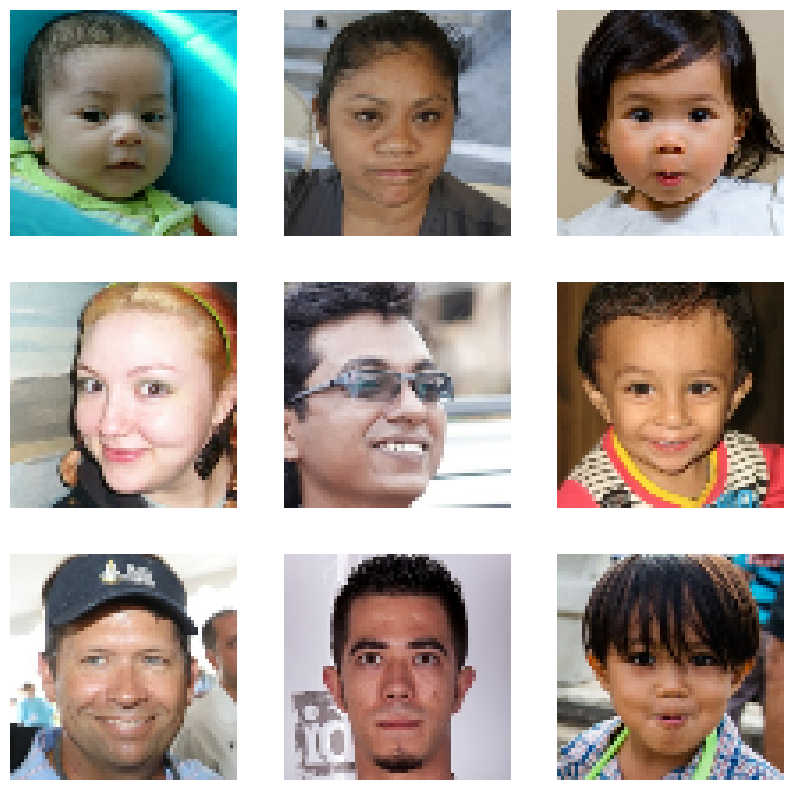

In [10]:
for batch in dataset.take(1):  # Take the first batch for display
    batch = (batch + 1) / 2
    plt.figure(figsize=(10, 10))
    for i in range(min(BATCH_SIZE, 9)):
        plt.subplot(3, 3, i + 1)
        plt.imshow(batch[i].numpy())
        plt.axis("off")
    plt.show()

In [11]:
len(dataset)

98

## GAN architecture

In [12]:
from keras.initializers import RandomNormal
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten, Reshape, ReLU, LeakyReLU, Dropout, Conv2DTranspose, BatchNormalization, ZeroPadding2D, UpSampling2D, Activation, MaxPooling2D

In [13]:
def build_generator():
    init = RandomNormal(stddev=0.02, seed=69)
    model = Sequential()

    model.add(Dense(2*2*512, input_dim=latent_features, kernel_initializer=init))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((2,2,512)))

    model.add(Conv2DTranspose(256, 4, 2,padding='same', kernel_initializer=init, use_bias=False))
    model.add(LeakyReLU(0.2))

    model.add(Conv2DTranspose(128, 4, 2,padding='same', kernel_initializer=init, use_bias=False))
    model.add(LeakyReLU(0.2))

    model.add(Conv2DTranspose(64, 4, 2,padding='same', kernel_initializer=init, use_bias=False))
    model.add(LeakyReLU(0.2))

    model.add(Conv2DTranspose(32, 4, 2,padding='same', kernel_initializer=init, use_bias=False))
    model.add(LeakyReLU(0.2))

    model.add(Conv2DTranspose(3, 4, 2,padding='same', activation='tanh', kernel_initializer=init, use_bias=False))

    return model

generator = build_generator()
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2048)              206848    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 2048)              0         
                                                                 
 reshape (Reshape)           (None, 2, 2, 512)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 4, 4, 256)         2097152   
 anspose)                                                        
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 8, 8, 128)         524288    
 Transpose)                                             

2024-02-10 05:33:16.717045: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


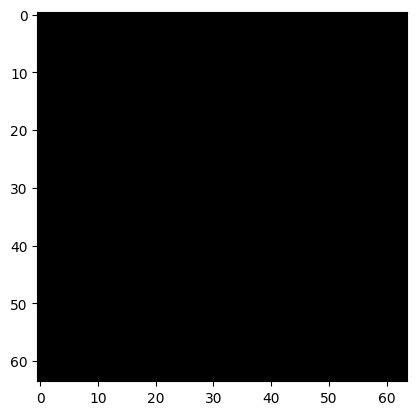

In [14]:
img = generator(np.random.normal(size=(1, latent_features, 1)))
plt.imshow(img[0])

In [15]:
def build_discriminator():
    init = RandomNormal(stddev=0.02, seed=69)
    model = Sequential()

    model.add(Conv2D(32, 4, 2, padding='same', input_shape = (image_width,image_height,3), kernel_initializer=init, use_bias=False))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, 4, 2, padding='same', kernel_initializer=init, use_bias=False))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, 4, 2, padding='same', kernel_initializer=init, use_bias=False))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.25))

    model.add(Conv2D(256, 4, 2, padding='same', kernel_initializer=init, use_bias=False))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.25))

    model.add(Conv2D(512, 4, 2, padding='same', kernel_initializer=init, use_bias=False))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.25))

    model.add(Conv2D(1024, 2, 1, kernel_initializer=init, use_bias=False))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

discriminator = build_discriminator()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        1536      
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 32, 32, 32)        0         
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        32768     
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 16, 16, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)        

In [16]:
img = generator.predict(np.random.normal(size=(4, latent_features, 1)))
discriminator.predict(img)

1/1 [==============================] - 1s 552ms/step


array([[0.49999124],
       [0.49999452],
       [0.4999954 ],
       [0.49999684]], dtype=float32)

## Training loop

In [17]:
# from keras.models import load_model
# generator = load_model('models/generator.h5')
# discriminator = load_model('models/discriminator.h5')

In [18]:
from keras.models import Model
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
from keras.utils import array_to_img
from keras.callbacks import Callback

In [19]:
class GAN(Model):
    def __init__(self, generator, discriminator, *args, **kwargs):
        # Pass through args and kwargs to base class
        super().__init__(*args, **kwargs)

        # Create attributes for gen and disc
        self.generator = generator
        self.discriminator = discriminator

    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
        # Compile with base class
        super().compile(*args, **kwargs)

        # Create attributes for losses and optimizers
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss

    def train_step(self, batch):
        # Train the discriminator
        with tf.GradientTape() as d_tape:
            real_images = batch
            ypred_real = self.discriminator(real_images, training=True)
            y_real = tf.ones_like(ypred_real)
            # noise_real = -0.10*tf.random.uniform(tf.shape(ypred_real))
            # y_real += noise_real
            real_d_loss = self.d_loss(y_real, ypred_real)
        # dgrad = d_tape.gradient(real_d_loss, self.discriminator.trainable_variables)
        # self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))

        # with tf.GradientTape() as d_tape:
            fake_images = self.generator(tf.random.normal((BATCH_SIZE, latent_features, 1)), training=False)
            ypred_fake = self.discriminator(fake_images, training=True)
            y_fake = tf.zeros_like(ypred_fake)
            # noise_fake = 0.10*tf.random.uniform(tf.shape(ypred_fake))
            # y_fake += noise_fake
            fake_d_loss = self.d_loss(y_fake, ypred_fake)

            total_d_loss = real_d_loss + fake_d_loss
        # Apply backpropagation - nn learn
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))

        # Train the generator
        with tf.GradientTape() as g_tape:
            gen_images = self.generator(tf.random.normal((BATCH_SIZE,latent_features,1)), training=True)
            predicted_labels = self.discriminator(gen_images, training=False)
            total_g_loss = self.g_loss(tf.ones_like(predicted_labels), predicted_labels)
        # Apply backprop
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))

        # return {"d_loss":total_d_loss, "g_loss":total_g_loss}
        return {"d_loss":total_d_loss, "g_loss":total_g_loss}

In [20]:
d_opt = Adam(learning_rate=0.0002,beta_1=0.5)
g_opt = Adam(learning_rate=0.0002,beta_1=0.5)
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

In [21]:
gan = GAN(generator, discriminator)
gan.compile(g_opt, d_opt, g_loss, d_loss)

In [22]:
class ModelMonitor(Callback):
    def __init__(self, latent_dim=latent_features):
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 5 == 0:
            random_latent_vectors = tf.random.uniform((1, self.latent_dim,1))
            generated_images = self.model.generator(random_latent_vectors)
            generated_images = (generated_images + 1) / 2
            generated_images = generated_images.numpy()
            img = array_to_img(generated_images[0])
            os.makedirs("training/", exist_ok=True)
            img.save(f'training/{epoch}_generated_img.png')
            os.makedirs("models/", exist_ok=True)
            generator.save('models/generator.h5')
            discriminator.save('models/discriminator.h5')


## Training

In [23]:
hist = gan.fit(dataset, epochs=500, callbacks=[ModelMonitor()])

Epoch 1/500


2024-02-10 05:33:43.284919: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-02-10 05:33:45.567144: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f089d6ebbb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-10 05:33:45.567171: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-02-10 05:33:45.580120: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1707543225.708830     879 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


98/98 [==============================] - 13s 73ms/step - d_loss: 0.7778 - g_loss: 0.6970
Epoch 2/500
 1/98 [..............................] - ETA: 4s - d_loss: 0.6807 - g_loss: 0.8416

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


98/98 [==============================] - 6s 59ms/step - d_loss: 0.7451 - g_loss: 0.7155
Epoch 3/500
98/98 [==============================] - 6s 59ms/step - d_loss: 0.7106 - g_loss: 0.7258
Epoch 4/500
98/98 [==============================] - 6s 59ms/step - d_loss: 0.7020 - g_loss: 0.7283
Epoch 5/500
98/98 [==============================] - 6s 58ms/step - d_loss: 0.6917 - g_loss: 0.7395
Epoch 6/500
98/98 [==============================] - 6s 59ms/step - d_loss: 0.6838 - g_loss: 0.7532
Epoch 7/500
98/98 [==============================] - 6s 58ms/step - d_loss: 0.6821 - g_loss: 0.7608
Epoch 8/500
98/98 [==============================] - 6s 57ms/step - d_loss: 0.6606 - g_loss: 0.7712
Epoch 9/500
98/98 [==============================] - 6s 59ms/step - d_loss: 0.6471 - g_loss: 0.7820
Epoch 10/500
98/98 [==============================] - 6s 60ms/step - d_loss: 0.6434 - g_loss: 0.7911
Epoch 11/500
98/98 [==============================] - 6s 60ms/step - d_loss: 0.6390 - g_loss: 0.8027
Epoch 12/5

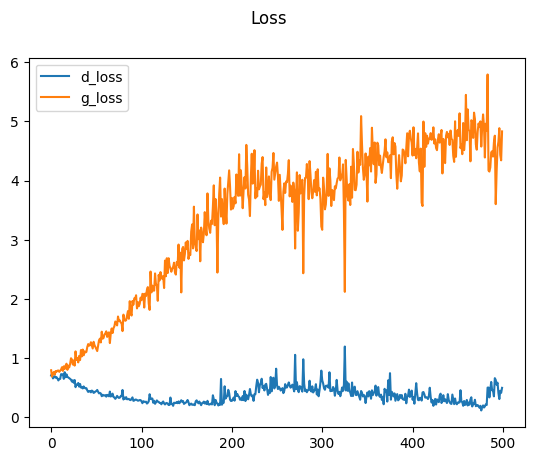

In [24]:
plt.suptitle('Loss')
plt.plot(hist.history['d_loss'], label='d_loss')
# plt.plot(hist.history['d_loss_real'], label='d_loss_real')
# plt.plot(hist.history['d_loss_fake'], label='d_loss_fake')
plt.plot(hist.history['g_loss'], label='g_loss')
plt.legend()
plt.show()

In [25]:
from PIL import Image
import imageio
import os

# Function to convert images to GIF
def convert_images_to_gif(input_folder, output_gif_path):
    images = []
    for filename in sorted(os.listdir(input_folder)):
        if filename.endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(input_folder, filename)
            img = Image.open(img_path)
            images.append(img)

    # Save images as GIF
    images[0].save(output_gif_path, save_all=True, append_images=images[1:], duration=200, loop=0)

# Example usage
input_folder = "training/"
output_gif_path = "training.gif"

convert_images_to_gif(input_folder, output_gif_path)

## Testing

1/1 [==============================] - 0s 171ms/step


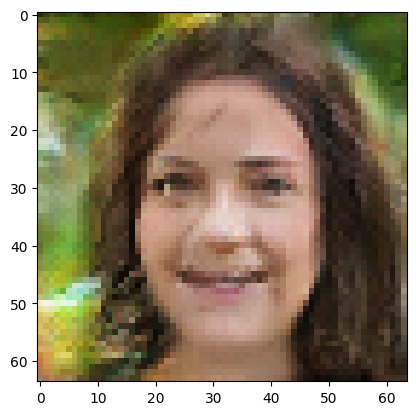

In [26]:
img = generator.predict(tf.random.normal((1, latent_features, 1)))
img = (img + 1) / 2
plt.imshow(img[0])